# Surrogate Model
### Training of Feedforward Neural Network with special architecture for Ordinal Classification

In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
import os
os.chdir("..")
from sklearn.preprocessing import StandardScaler
from src.models.ordinal_classifier_fnn import *
from src.models.coral_loss import *
from src.data.sm_dataloader import *
from src.preprocessing.sm_label_transformer import *
import torch.nn.functional as F
from sklearn.metrics import mean_absolute_error

C:\Users\sarah\Anaconda3\lib\site-packages\scipy\__init__.py:137: UserWarning: NumPy 1.16.5 or above is required for this version of SciPy (detected version 1.16.1)
  UserWarning)


### 1. Set seeds

In [2]:
# Set seeds in order to reproduce results
torch.manual_seed(73)
random.seed(73)
np.random.seed(73)

### 2. Load dataset

In [3]:
# Replace by true labeled dataset if available
train_dataset = DatasetSM(train=True, path="data/surrogate_model")
test_dataset = DatasetSM(train=False, path="data/surrogate_model")
train_dataset.X.shape

torch.Size([10769, 38])

In [4]:
train_dataset.X

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0395,  0.0514, 24.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.7143,  0.7070, 24.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.7143,  0.7786, 24.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.8615,  0.5000, 24.0000],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.6105,  0.4907, 24.0000],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.8615,  0.5000, 24.0000]])

In [5]:
train_dataset.y

tensor([[1., 1., 1., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 0.],
        ...,
        [1., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

### 3. Scale training and test data

In [6]:
#scaler = StandardScaler()

# only scale numeric variables that are not one-hot encoded
#scaler.fit(train_dataset.X[:, 6:])
#train_dataset.scale(scaler)
#test_dataset.scale(scaler)

In [7]:
train_dataset.X

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0395,  0.0514, 24.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.7143,  0.7070, 24.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.7143,  0.7786, 24.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.8615,  0.5000, 24.0000],
        [ 1.0000,  0.0000,  0.0000,  ...,  0.6105,  0.4907, 24.0000],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.8615,  0.5000, 24.0000]])

### 4. Upscaling of class 4/"Very Good" (optional, was shown to not improve the performance)

In [8]:
# Get indices where data label equals 4
#label_counts = {i: len(np.where(torch.sum(train_dataset.y, axis=1) == i)[0]) for i in range(5)}
#i_class4 = np.where(torch.sum(train_dataset.y, axis=1) == 4)[0]
# Calculate upsample size (mean of class sizes 0-3 - class size 4)
#upsample_size = round(np.mean([label_counts[i] for i in range(4)])) - label_counts[4]
# Get upsample indices
#i_class4_upsampled = np.random.choice(i_class4, size=upsample_size, replace=True)

In [9]:
# Create upsampled dataframe
#train_dataset.y = torch.vstack([train_dataset.y, train_dataset.y[i_class4_upsampled]])
#train_dataset.X = torch.vstack([train_dataset.X, train_dataset.X[i_class4_upsampled]])
#train_dataset.X.shape

### 5. Train model

#### 5.1 Build model and switch to GPU if available

In [10]:
fitness_function = OrdinalClassifierFNN(num_classes=5, layer_sizes=[38,28])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
fitness_function.to(device)

cpu


OrdinalClassifierFNN(
  (hidden): ModuleList(
    (0): Linear(in_features=38, out_features=28, bias=True)
  )
  (coral_weights): Linear(in_features=28, out_features=1, bias=False)
)

In [11]:
res = fitness_function(test_dataset.X[:5])
print(res)
torch.sigmoid(res)

tensor([[-2.3060, -2.5560, -2.8060, -3.0560],
        [-2.3060, -2.5560, -2.8060, -3.0560],
        [-2.3743, -2.6243, -2.8743, -3.1243],
        [-2.3060, -2.5560, -2.8060, -3.0560],
        [-2.5467, -2.7967, -3.0467, -3.2967]], grad_fn=<AddBackward0>)


tensor([[0.0906, 0.0720, 0.0570, 0.0450],
        [0.0906, 0.0720, 0.0570, 0.0450],
        [0.0852, 0.0676, 0.0534, 0.0421],
        [0.0906, 0.0720, 0.0570, 0.0450],
        [0.0726, 0.0575, 0.0454, 0.0357]], grad_fn=<SigmoidBackward>)

#### 5.2 Define optimizer and additional measure to report (optional)

In [12]:
#criterion = nn.L1Loss()
report_measure = nn.L1Loss()
optimizer = torch.optim.Adam(fitness_function.parameters())

#### 5.3 Define Data loaders

In [13]:
# Useful because it automatically generates batches in the training loop and takes care of shuffling

batch_size = 128
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

#### 5.4 Actual Model training

In [14]:
n_epochs = 100

# Stuff to store
train_losses = np.zeros(n_epochs)
train_bin_maes = np.zeros(n_epochs)
train_accuracies = np.zeros(n_epochs)
train_label_maes = np.zeros(n_epochs)

test_losses = np.zeros(n_epochs)
test_bin_maes = np.zeros(n_epochs)
test_accuracies = np.zeros(n_epochs)
test_label_maes = np.zeros(n_epochs)


for it in range(n_epochs):
    train_loss = []
    test_loss = []
    train_bin_mae = []
    test_bin_mae = []
    train_label_mae = []
    test_label_mae = []
    correct_train = 0
    correct_test = 0
    for inputs, targets in train_loader:
        # move data to GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = fitness_function(inputs)
        loss = coral_loss(outputs, targets)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Store loss and other report measures
        train_loss.append(loss.item())
        train_bin_mae.append(report_measure(torch.sigmoid(outputs), targets).item())
        train_label_mae.append(mean_absolute_error(decode_classes(targets), decode_classes(torch.sigmoid(outputs))))
        
        # Count correct predictions
        correct_train += (decode_classes(torch.sigmoid(outputs)) == decode_classes(targets)).sum()
        
    # Get train loss and test loss
    train_loss = np.mean(train_loss)
    train_bin_mae = np.mean(train_bin_mae)
    train_label_mae = np.mean(train_label_mae)
    
    # Get train accuracy
    train_accuracy = correct_train / len(train_dataset.X)
    
    predicted_classes = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = fitness_function(inputs)
        loss = coral_loss(outputs, targets)
        test_loss.append(loss.item())
        test_bin_mae.append(report_measure(torch.sigmoid(outputs), targets).item())
        test_label_mae.append(mean_absolute_error(decode_classes(targets), decode_classes(torch.sigmoid(outputs))))
        correct_test += (decode_classes(torch.sigmoid(outputs)) == decode_classes(targets)).sum()
    test_loss = np.mean(test_loss)
    test_bin_mae = np.mean(test_bin_mae)
    test_label_mae = np.mean(test_label_mae)
    test_accuracy = correct_test / len(test_dataset.X)

    # Save losses
    train_losses[it] = train_loss
    train_bin_maes[it] = train_bin_mae
    test_losses[it] = test_loss
    test_bin_maes[it] = test_bin_mae
    train_label_maes[it] = train_label_mae
    test_label_maes[it] = test_label_mae
    train_accuracies[it] = train_accuracy
    test_accuracies[it] = test_accuracy

    if (it + 1) % 10 == 0 or it==0:
        print(f'Epoch {it + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}'
              f' Train Binary MAE: {train_bin_mae:.4f}, Test Binary MAE: {test_bin_mae:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Train Label MAE:  {train_label_mae:.4f}, Test Label MAE:  {test_label_mae:.4f}')

Epoch 1/100, Train Loss: 4.8096, Test Loss: 2.6990 Train Binary MAE: 0.4451, Test Binary MAE: 0.4253, Train Accuracy: 0.1949, Test Accuracy: 0.2305, Train Label MAE:  1.6516, Test Label MAE:  1.4588
Epoch 10/100, Train Loss: 1.9269, Test Loss: 2.1358 Train Binary MAE: 0.3432, Test Binary MAE: 0.3483, Train Accuracy: 0.4041, Test Accuracy: 0.3512, Train Label MAE:  0.8346, Test Label MAE:  1.0300
Epoch 20/100, Train Loss: 1.7718, Test Loss: 1.8472 Train Binary MAE: 0.3041, Test Binary MAE: 0.3156, Train Accuracy: 0.4219, Test Accuracy: 0.3799, Train Label MAE:  0.7644, Test Label MAE:  0.8193
Epoch 30/100, Train Loss: 1.7035, Test Loss: 1.7736 Train Binary MAE: 0.2842, Test Binary MAE: 0.2879, Train Accuracy: 0.4170, Test Accuracy: 0.4188, Train Label MAE:  0.7532, Test Label MAE:  0.7648
Epoch 40/100, Train Loss: 1.6837, Test Loss: 1.7729 Train Binary MAE: 0.2744, Test Binary MAE: 0.2788, Train Accuracy: 0.4138, Test Accuracy: 0.4176, Train Label MAE:  0.7511, Test Label MAE:  0.7698
E

### 6. Evaluate model performance

#### 6.1 Compute benchmark performance values

In [15]:
unique_train, counts_train = np.unique(decode_classes(train_dataset.y).flatten(), return_counts=True)
display(len(train_dataset))
dict(zip(unique_train, counts_train))

10769

{0: 2580, 1: 2143, 2: 3752, 3: 1892, 4: 402}

In [16]:
unique_test, counts_test = np.unique(decode_classes(test_dataset.y).flatten(), return_counts=True)
display(len(test_dataset.y))
dict(zip(unique_test, counts_test))

2469

{0: 498, 1: 414, 2: 918, 3: 532, 4: 107}

In [17]:
# Accuracy for majority classifier
print(f'Test Benchmark Accuracy: {375/1238 :.4f}')

Test Benchmark Accuracy: 0.3029


In [18]:
# Label MAE for constant prediction of class 2
print(f'Test Benchmark Label MAE: {2*(238+72)/1238 + 1*(205+375)/1238 :.4f}')

Test Benchmark Label MAE: 0.9693


In [19]:
# Binary MAE for constant prediction of class 2 (1,1,0,0)
print(f'Test Benchmark Binary MAE: {(238*0.5 + 205*0.25 + 375*0.25 + 72*0.5)/1238 :.4f}')

Test Benchmark Binary MAE: 0.2423


#### 6.2 Plot the train loss and test loss per epoch

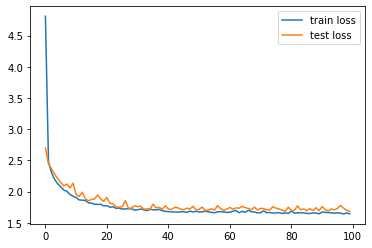

In [20]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

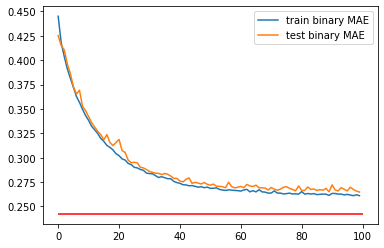

In [21]:
plt.plot(train_bin_maes, label='train binary MAE')
plt.plot(test_bin_maes, label='test binary MAE')
plt.hlines(0.2423, xmin=0, xmax=100, color='red')
plt.legend()
plt.show()

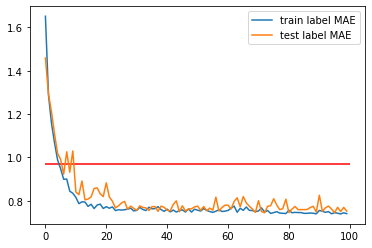

In [22]:
plt.plot(train_label_maes, label='train label MAE')
plt.plot(test_label_maes, label='test label MAE')
plt.hlines(0.9693, xmin=0, xmax=100, color='red')
plt.legend()
plt.show()

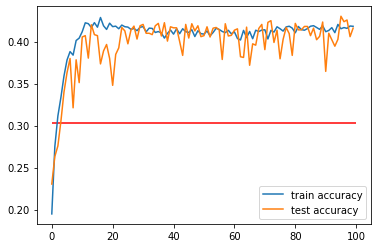

In [23]:
plt.plot(train_accuracies, label='train accuracy')
plt.plot(test_accuracies, label='test accuracy')
plt.hlines(0.3029, xmin=0, xmax=100, color='red')
plt.legend()
plt.show()

### 7. Save and load trained model

#### 7.1 Save model

In [25]:
torch.save(fitness_function.state_dict(), "models/sm_fnn.pth")

#### 7.2. Load model and make predictions

In [33]:
model = OrdinalClassifierFNN(num_classes=5, layer_sizes=[38,28])
model.load_state_dict(torch.load("models/sm_fnn.pth"))
model.eval()

OrdinalClassifierFNN(
  (hidden): ModuleList(
    (0): Linear(in_features=38, out_features=28, bias=True)
  )
  (coral_weights): Linear(in_features=28, out_features=1, bias=False)
)

In [34]:
inp = test_dataset.X[0:20]
output = model(inp)

In [35]:
output

tensor([[ 1.0883, -0.2543, -1.7768, -3.6158],
        [ 1.0883, -0.2543, -1.7768, -3.6158],
        [-1.8299, -3.1724, -4.6949, -6.5339],
        [ 1.0883, -0.2543, -1.7768, -3.6158],
        [ 1.0155, -0.3270, -1.8495, -3.6885],
        [ 0.9790, -0.3635, -1.8860, -3.7250],
        [ 1.3780,  0.0355, -1.4871, -3.3261],
        [ 2.6426,  1.3001, -0.2225, -2.0615],
        [ 0.1850, -1.1575, -2.6800, -4.5190],
        [ 2.5385,  1.1960, -0.3265, -2.1655],
        [ 0.1653, -1.1772, -2.6997, -4.5387],
        [ 2.6420,  1.2995, -0.2230, -2.0620],
        [ 2.4489,  1.1064, -0.4161, -2.2551],
        [ 0.8743, -0.4682, -1.9907, -3.8297],
        [-1.3702, -2.7127, -4.2352, -6.0742],
        [ 2.0184,  0.6759, -0.8466, -2.6856],
        [-0.6775, -2.0200, -3.5425, -5.3816],
        [ 2.0209,  0.6784, -0.8442, -2.6832],
        [-1.3372, -2.6797, -4.2023, -6.0413],
        [ 1.5923,  0.2498, -1.2728, -3.1118]], grad_fn=<AddBackward0>)